In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

In [147]:
data= pd.read_csv('Data\PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()
#Label 1 corresponds to a legitimate URL, label 0 to a phishing URL


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [31]:
data.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

### Data Cleaning

##### We combined several features that can have large variations using Harmonic mean

##### $$ \text{Harmonic mean} =  \frac{n}{\sum_{i=1}^{n}\frac{1}{x_i}} $$
- Harmonic mean penalizes large outliers, giving more weight to smaller values.

In [157]:
url_features = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain', 'NoOfLettersInURL', 'NoOfDegitsInURL']
html_features = ['NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'NoOfPopup', 'NoOfiFrame']

def calculate_harmonic_mean(row,url):
    values = row[url]
    non_zero_values = [x for x in values if x > 0]
    
    if len(non_zero_values) > 0:
        return hmean(non_zero_values)
    else:
        return 0
    


data['HarmonicMean_URL'] = data.apply(calculate_harmonic_mean, axis=1,url=url_features)

data['HarmonicMean_HTML'] = data.apply(calculate_harmonic_mean, axis=1,url=html_features)


data[['HarmonicMean_URL', 'HarmonicMean_HTML']].head()


,HarmonicMean_URL,HarmonicMean_HTML
0,3.418070,5.302255
1,2.911904,17.460513
2,4.360704,4.090909
3,3.330337,3.079193
4,3.443294,4.305492


#### Logistic regression coefficient
- As it is a binary classification data, we cannot have correlation coefficient. So we have used logistic regression for logistic regression coefficient.
- It helps us understand how each feature influences the binary classification (1 for legitimate, 0 for phishing). 

In [161]:
from sklearn.linear_model import LogisticRegression

# Prepare data
x = data[['HarmonicMean_URL']]
y = data['label']

X = data[['HarmonicMean_HTML']]
Y = data['label']


log_reg = LogisticRegression()

log_reg.fit(x, y)
coef = log_reg.coef_[0][0]
print(f"Coefficient of Harmonic Mean Length using url components: {coef}")


log_reg.fit(X, Y)
coef = log_reg.coef_[0][0]

print(f"Coefficient of Harmonic Mean Length using html components: {coef}")

Coefficient of Harmonic Mean Length using url components: -0.8260254219580696
Coefficient of Harmonic Mean Length using html components: 1.7736593543974766


##### Plotting graph for URL components and HTML components w.r.t logistic regression coefficient

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming df is your DataFrame and the harmonic mean feature is calculated
url_features = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain', 'NoOfLettersInURL', 'HarmonicMean_URL']
html_features = ['NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfSelfRedirect','NoOfURLRedirect','NoOfExternalRef', 'NoOfPopup', 'NoOfiFrame','HarmonicMean_HTML']

# Prepare a DataFrame to store coefficients
coefficients_url = []
coefficients_html = []


In [163]:
# Fit models for URL components
for feature in url_features:
    X = data[[feature]]
    y = data['label']
    
    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    
    coefficients_url.append({
        'Feature': feature,
        'Coefficient': log_reg.coef_[0][0]
    })

# Fit models for HTML components
for feature in html_features:
    X = data[[feature]]
    y = data['label']
    
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    coefficients_html.append({
        'Feature': feature,
        'Coefficient': log_reg.coef_[0][0]
    })



In [164]:
# Create DataFrames for easy plotting
coef_url_df = pd.DataFrame(coefficients_url)
coef_html_df = pd.DataFrame(coefficients_html)

# Sortting the DataFrames by absolute value of coefficients
coef_url_df['AbsCoefficient'] = coef_url_df['Coefficient'].abs()
coef_url_df = coef_url_df.sort_values(by='AbsCoefficient', ascending=False)

coef_html_df['AbsCoefficient'] = coef_html_df['Coefficient'].abs()
coef_html_df = coef_html_df.sort_values(by='AbsCoefficient', ascending=False)

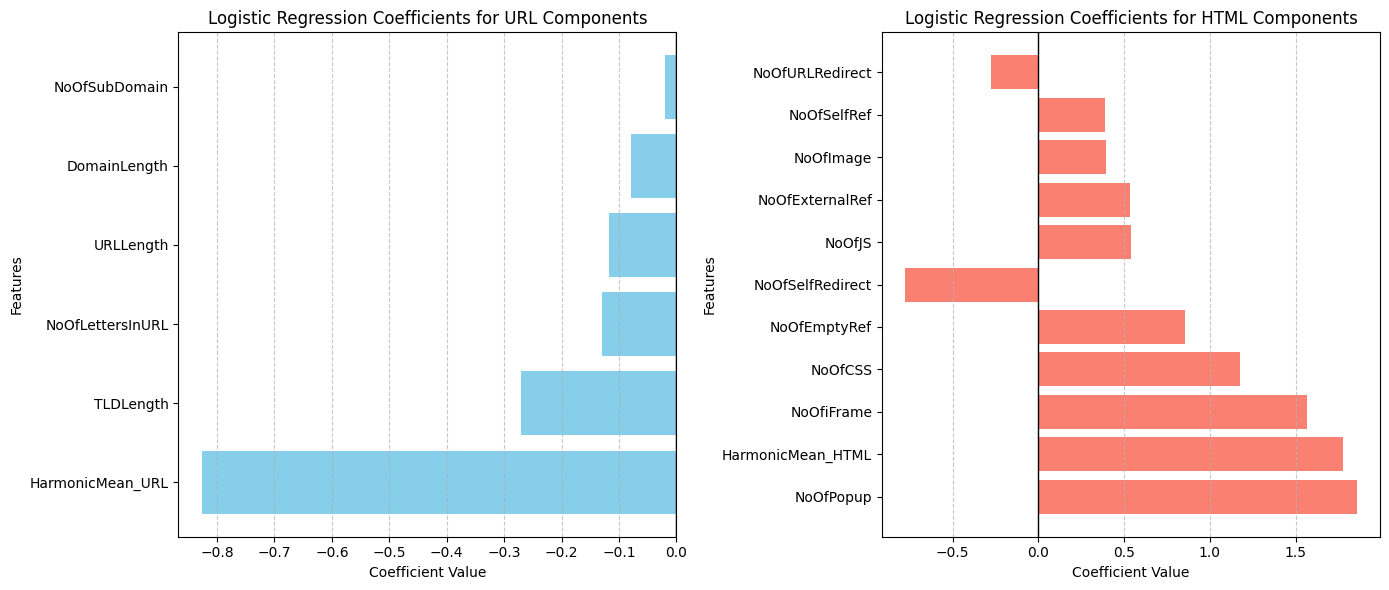

In [165]:
# Step 6: Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for URL components
axs[0].barh(coef_url_df['Feature'], coef_url_df['Coefficient'], color='skyblue')
axs[0].axvline(0, color='black', lw=1)  # Add a vertical line at 0
axs[0].set_title('Logistic Regression Coefficients for URL Components')
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot for HTML components
axs[1].barh(coef_html_df['Feature'], coef_html_df['Coefficient'], color='salmon')
axs[1].axvline(0, color='black', lw=1)  # Add a vertical line at 0
axs[1].set_title('Logistic Regression Coefficients for HTML Components')
axs[1].set_xlabel('Coefficient Value')
axs[1].set_ylabel('Features')
axs[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- URL Complexity: Longer and more complex URLs are associated with a higher likelihood of being phishing (label 0), as indicated by negative coefficients for features like HarmonicMean_URL, NoOfSubDomain, and DomainLength.

- Harmonic Mean of URL: The negative coefficient for HarmonicMean_URL (-0.82) suggests that a lower harmonic mean (indicative of simpler URL structures) correlates with a higher likelihood of being legitimate (label 1).

- HTML Complexity: In contrast, the HarmonicMean_HTML has a positive coefficient (~1.8), indicating that more complex HTML features are linked to legitimate URLs (label 1).

- Impact of Popups: The positive coefficient for NoOfPopup implies that URLs with more popups are more likely to be legitimate (label 1), contrary to common perceptions.

- Self-Redirects: A strong negative coefficient for NoOfSelfRedirect suggests that self-redirects are indicative of phishing URLs (label 0).

The above analysis shows that while URL complexity tends to point towards phishing URLs, HTML complexity may often reflect legitimate sites, highlighting the nuanced relationship between web features and URL legitimacy.

### Shannon Entropy (H)
- Entropy is a measure of the randomness or unpredictability of information. 
- Higher entropy typically indicates more randomness in the characters of the URL components, which is often a characteristic of phishing URLs.

#### $$H= -∑(p(x)log_2 p(x))$$

In [166]:
import pandas as pd
import numpy as np
from collections import Counter
import math


# Function to calculate Shannon entropy
def calculate_entropy(text):
    frequency = Counter(text)
    total_len = len(text)

    entropy = -sum((count / total_len) * math.log2(count / total_len) for count in frequency.values())
    return entropy

# Function to extract domain, path, and query from the URL
from urllib.parse import urlparse

def extract_url_components(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc, parsed_url.path, parsed_url.query

data['DomainEntropy'] = data['URL'].apply(lambda url: calculate_entropy(extract_url_components(url)[0]))
data['PathEntropy'] = data['URL'].apply(lambda url: calculate_entropy(extract_url_components(url)[1]))
data['QueryEntropy'] = data['URL'].apply(lambda url: calculate_entropy(extract_url_components(url)[2]))

# Display the new entropy columns
print(data[['DomainEntropy', 'PathEntropy', 'QueryEntropy']].head())


   DomainEntropy  PathEntropy  QueryEntropy
0       3.657268          0.0           0.0
1       3.327820          0.0           0.0
2       3.629220          0.0           0.0
3       3.576618          0.0           0.0
4       3.430457          0.0           0.0


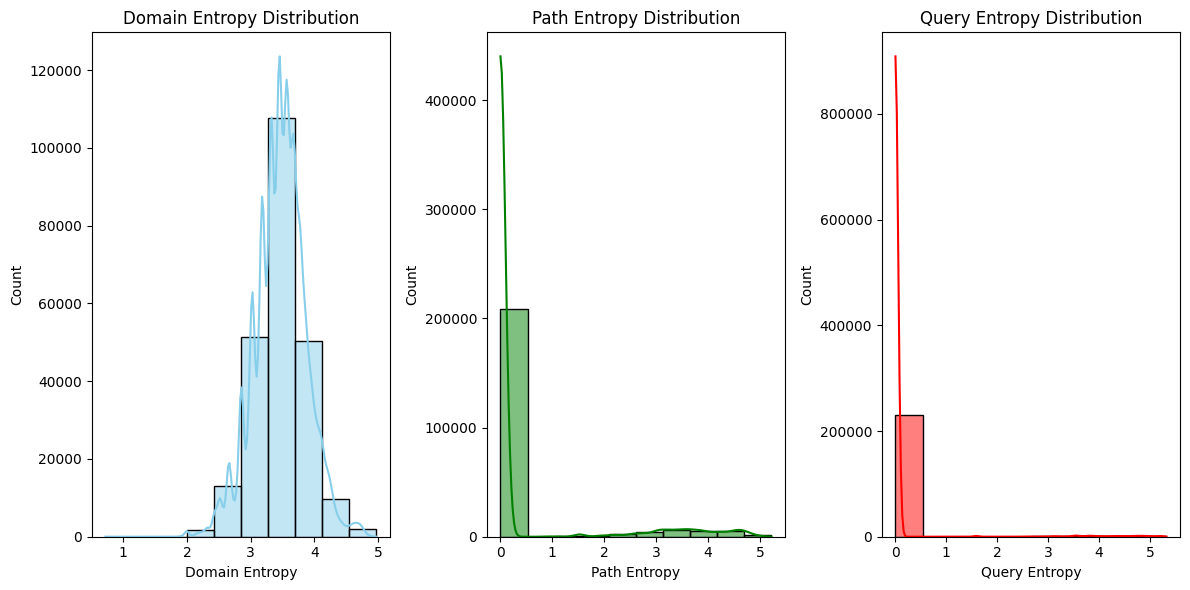

In [167]:
# Plot the entropies
plt.figure(figsize=(12, 6))


plt.subplot(1, 3, 1)
sns.histplot(data['DomainEntropy'], bins=10, kde=True, color='skyblue')
plt.title('Domain Entropy Distribution')
plt.xlabel('Domain Entropy')

plt.subplot(1, 3, 2)
sns.histplot(data['PathEntropy'], bins=10, kde=True, color='green')
plt.title('Path Entropy Distribution')
plt.xlabel('Path Entropy')

plt.subplot(1, 3, 3)
sns.histplot(data['QueryEntropy'], bins=10, kde=True, color='red')
plt.title('Query Entropy Distribution')
plt.xlabel('Query Entropy')

plt.tight_layout()
plt.show()


1. **Domain Entropy**:
   - The distribution of domain entropy values predominantly falls between **3 and 4**, suggesting that most domains possess a moderate level of character randomness.
   - This moderate randomness may reflect common practices in domain selection, making it a useful feature for distinguishing between phishing and legitimate URLs.

2. **Path Entropy**:
   - Most path entropy values are clustered around **zero**, with a long tail extending to higher values. This indicates that many URLs either lack a path or have highly structured, predictable paths.
   - The few URLs with high path entropy could potentially indicate phishing URLs that obfuscate their intentions.

3. **Query Entropy**:
   - Similar to path entropy, the query entropy distribution shows a majority of values near **zero**, suggesting that many URLs do not utilize complex query strings.
   - A small portion of URLs exhibit high query entropy, which may signify attempts to confuse users, characteristic of phishing behavior.

The entropy analysis reveals that URL components exhibit varying degrees of randomness, which can be leveraged to enhance phishing detection models. Further analysis will be conducted to assess the effectiveness of these features in predicting phishing URLs.


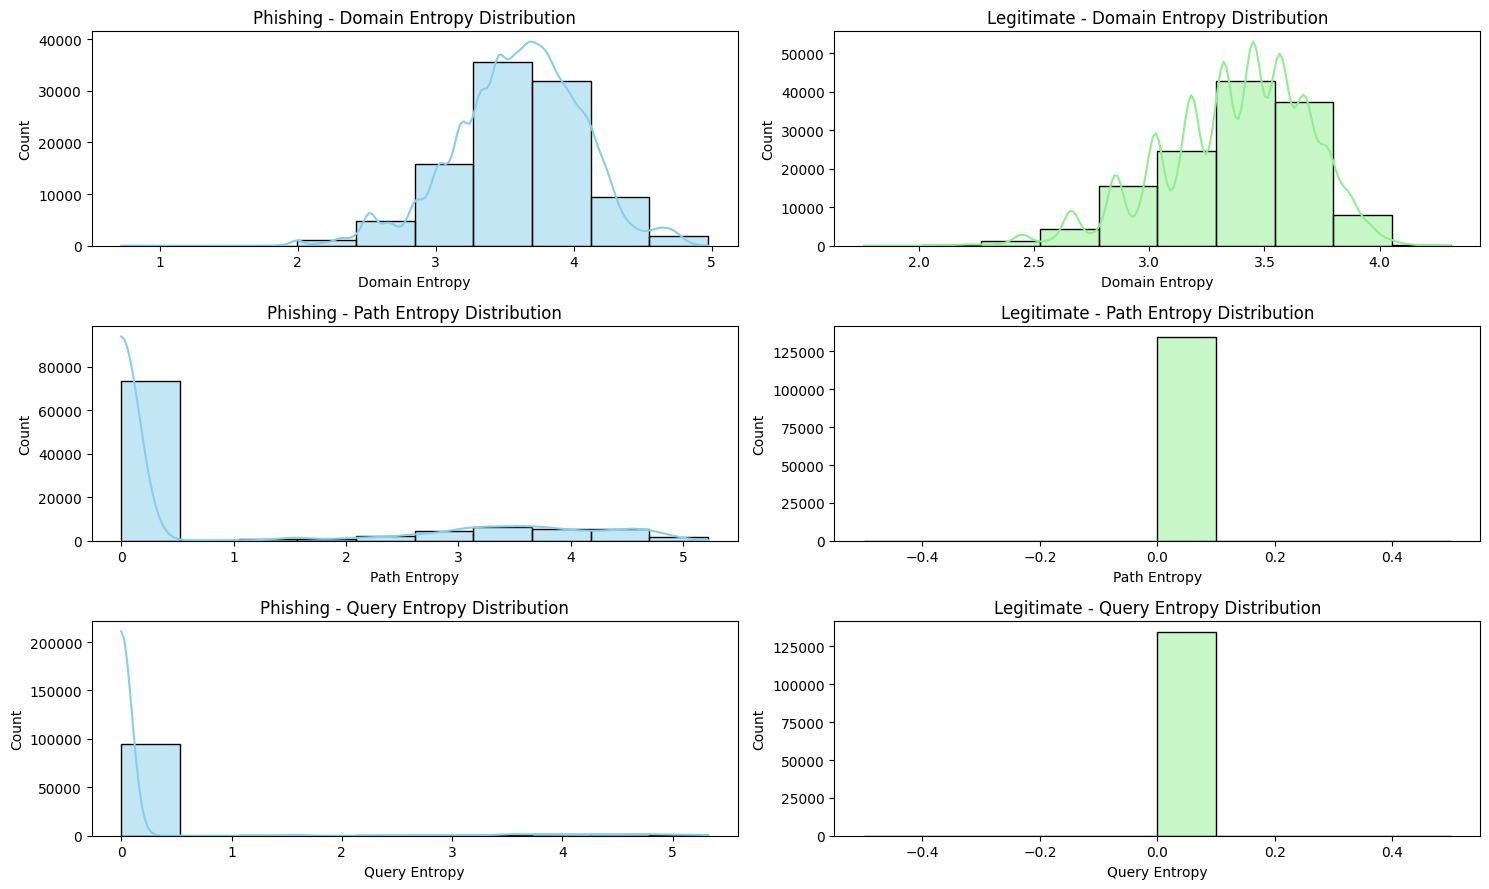

In [168]:
# Split the data into phishing and legitimate based on the 'label' column
phishing_data = data[data['label'] == 0]
legitimate_data = data[data['label'] == 1]

# Set up the figure and axes for the subplots
plt.figure(figsize=(15, 9))

# Domain Entropy for Phishing vs Legitimate URLs
plt.subplot(3, 2, 1)
sns.histplot(phishing_data['DomainEntropy'], bins=10, kde=True, color='skyblue', label='Phishing')
plt.title('Phishing - Domain Entropy Distribution')
plt.xlabel('Domain Entropy')

plt.subplot(3, 2, 2)
sns.histplot(legitimate_data['DomainEntropy'], bins=10, kde=True, color='lightgreen', label='Legitimate')
plt.title('Legitimate - Domain Entropy Distribution')
plt.xlabel('Domain Entropy')

# Path Entropy for Phishing vs Legitimate URLs
plt.subplot(3, 2, 3)
sns.histplot(phishing_data['PathEntropy'], bins=10, kde=True, color='skyblue', label='Phishing')
plt.title('Phishing - Path Entropy Distribution')
plt.xlabel('Path Entropy')

plt.subplot(3, 2, 4)
sns.histplot(legitimate_data['PathEntropy'], bins=10, kde=True, color='lightgreen', label='Legitimate')
plt.title('Legitimate - Path Entropy Distribution')
plt.xlabel('Path Entropy')

# Query Entropy for Phishing vs Legitimate URLs
plt.subplot(3, 2, 5)
sns.histplot(phishing_data['QueryEntropy'], bins=10, kde=True, color='skyblue', label='Phishing')
plt.title('Phishing - Query Entropy Distribution')
plt.xlabel('Query Entropy')

plt.subplot(3, 2, 6)
sns.histplot(legitimate_data['QueryEntropy'], bins=10, kde=True, color='lightgreen', label='Legitimate')
plt.title('Legitimate - Query Entropy Distribution')
plt.xlabel('Query Entropy')

plt.tight_layout()
plt.show()


1. **Path and Query Entropy**:
   - The plot clearly demonstrates that legitimate URLs exhibit only **zero values** for both path and query entropy, indicating a lack of complexity in their structure.
   - In contrast, phishing URLs display a small tail in both path and query entropy, suggesting that some phishing attempts utilize more complex structures to trick users.

2. **Domain Entropy**:
   - The distribution of domain entropy remains relatively similar for both phishing and legitimate URLs, with no significant differentiation observed. 
   - This suggests that domain randomness alone may not be a sufficient indicator for phishing detection.

Overall, the entropy analysis highlights the stark differences in path and query complexity between legitimate and phishing URLs. While legitimate URLs tend to maintain a simple and predictable structure, phishing URLs show occasional complexity in their paths and queries

### EDA

In [135]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [136]:
print(data.describe())

           URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min          

In [137]:
# Checking for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


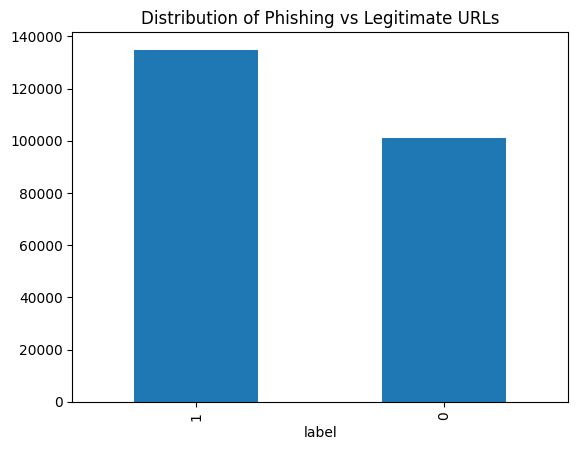

In [138]:
# Distribution of the target variable
data['label'].value_counts().plot(kind='bar', title="Distribution of Phishing vs Legitimate URLs")
plt.show()


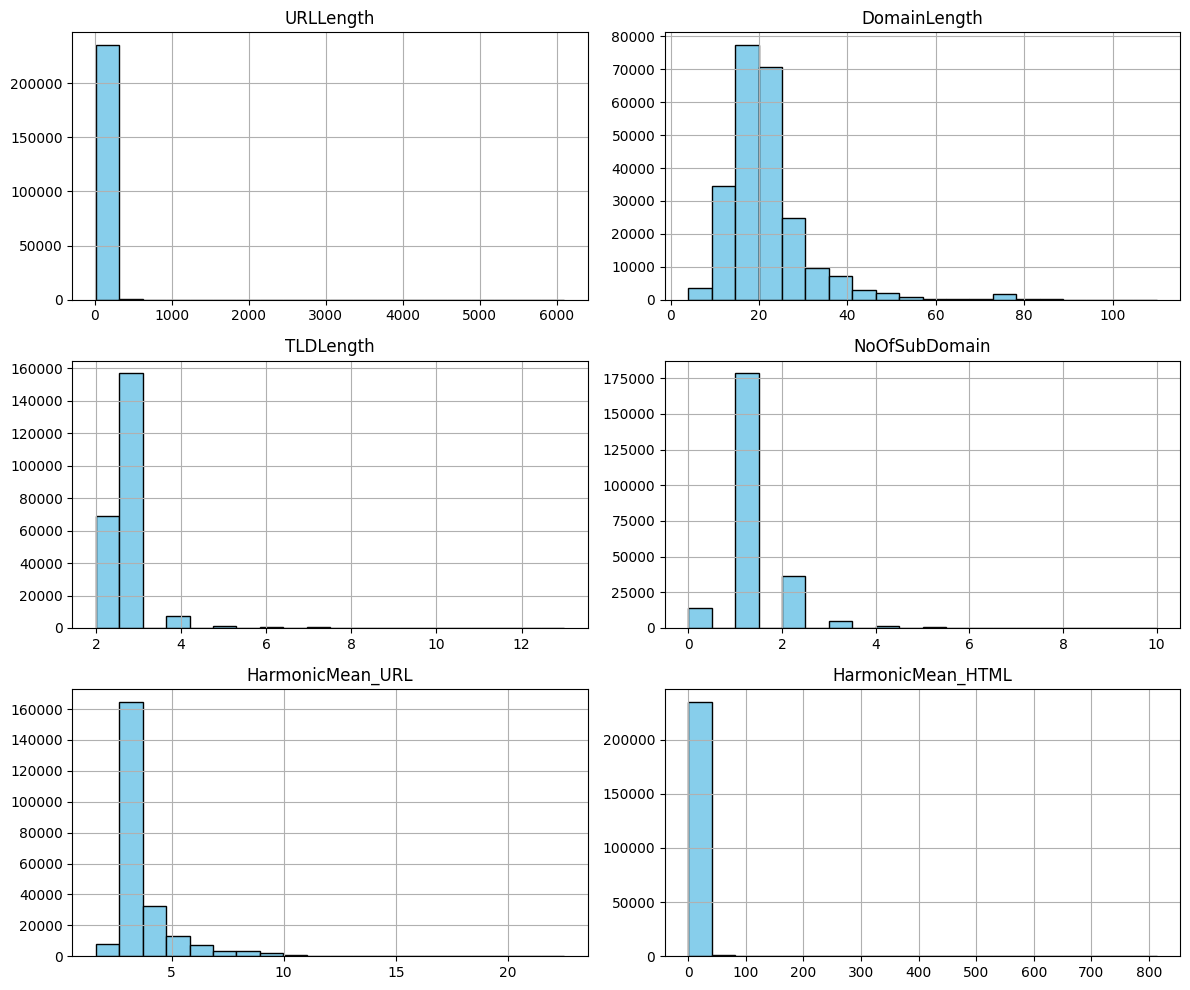

In [139]:
# Plot histograms of important features
important_features = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain', 'HarmonicMean_URL', 'HarmonicMean_HTML']

data[important_features].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()


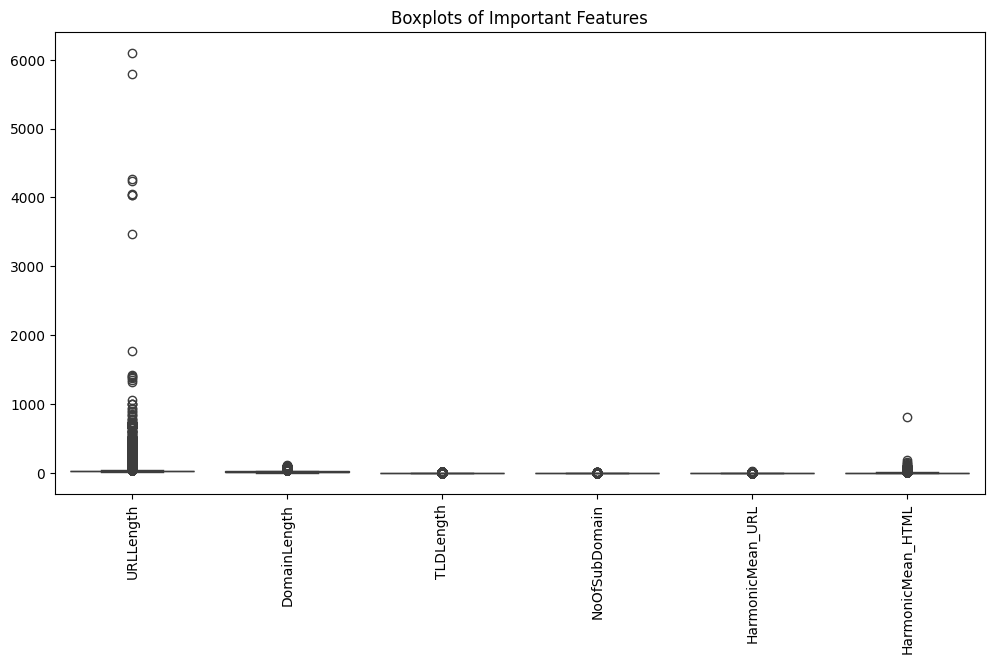

In [140]:
# Boxplots to detect outliers in features
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[important_features])
plt.xticks(rotation=90)
plt.title('Boxplots of Important Features')
plt.show()


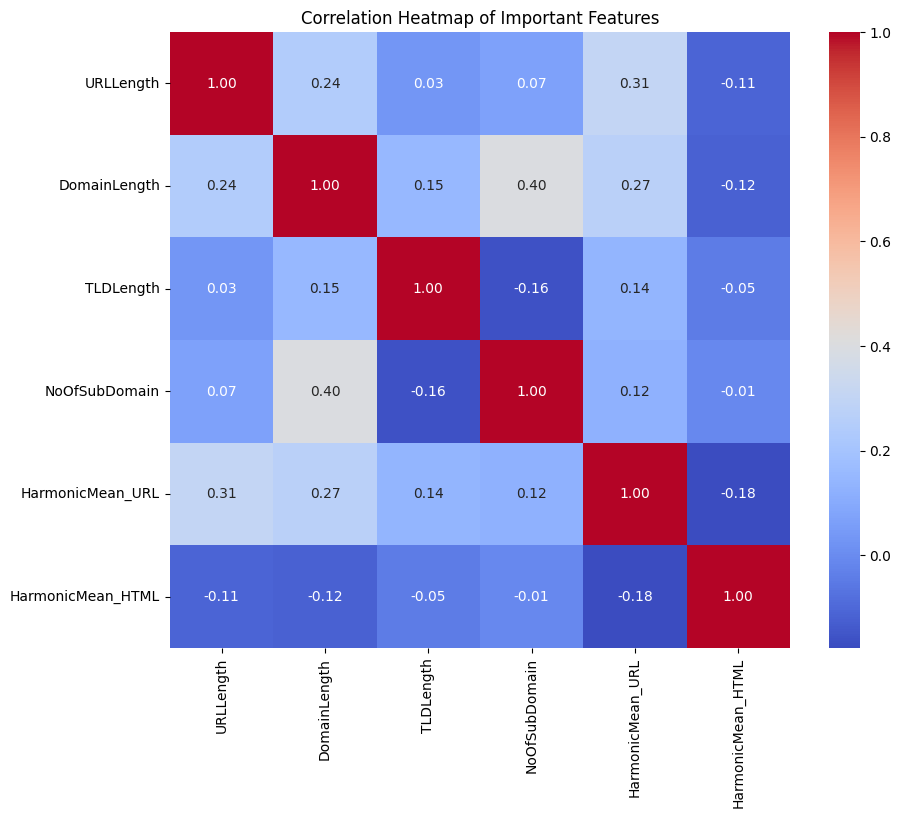

In [141]:
# Correlation matrix
corr_matrix = data[important_features].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Important Features')
plt.show()


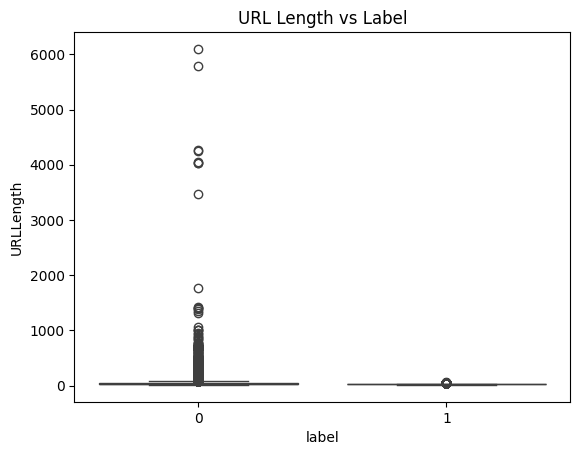

In [142]:
# Boxplot of URL length for phishing and legitimate URLs
sns.boxplot(x='label', y='URLLength', data=data)
plt.title('URL Length vs Label')
plt.show()


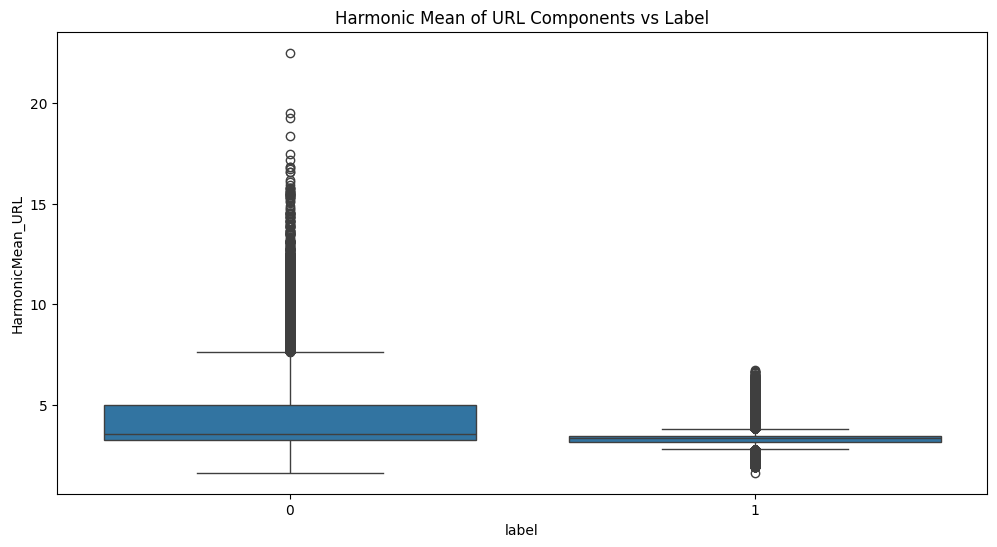

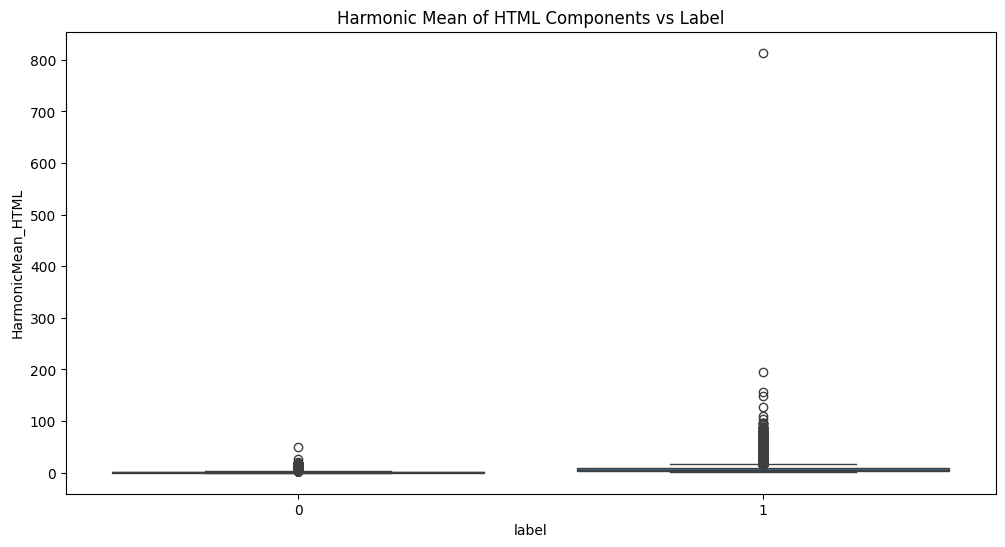

In [144]:
# Boxplot of harmonic means for phishing and legitimate URLs
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='HarmonicMean_URL', data=data)
plt.title('Harmonic Mean of URL Components vs Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='HarmonicMean_HTML', data=data)
plt.title('Harmonic Mean of HTML Components vs Label')
plt.show()


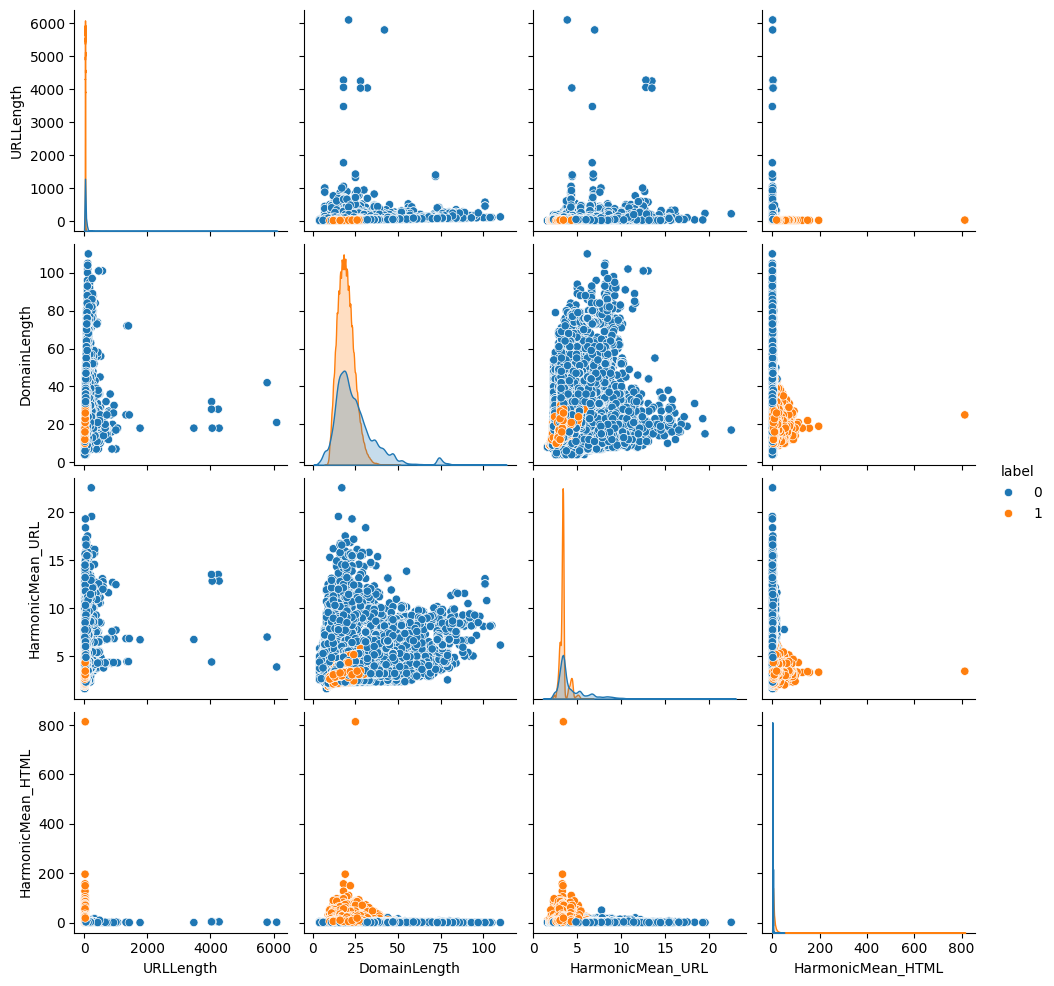

In [145]:
# Pairplot to visualize feature interactions
sns.pairplot(data[['URLLength', 'DomainLength', 'HarmonicMean_URL', 'HarmonicMean_HTML', 'label']], hue='label')
plt.show()
